In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wf_psf
from tqdm import tqdm

In [2]:
# Paths

# SED folder path
SED_path = './../../../wf-psf/data/SEDs/save_SEDs/'

# Output saving path (in node05 of candide)
output_folder = './../../../../../n05data/ecentofanti/WFE_sampling_test/multires_dataset/'

In [71]:
# Dataset ID
dataset_id = 1
dataset_id_str = '%03d'%(dataset_id)


# This list must be in order from bigger to smaller
n_star_list = [1]
n_test_stars = 1  # 20% of the max test stars


# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
auto_init = True
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

# Desired WFE resolutions in increasing order
WFE_resolutions = [256, 1024, 4096]

In [72]:
zernikes_multires = []
sim_PSF_toolkit_multires = []
gen_poly_fieldPSF_multires = []

for i, pupil_diameter_ in tqdm(enumerate(WFE_resolutions)):

    # Generate Zernike maps in max resolution
    zernikes_multires.append( wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter_) )

    # Initialize PSF simulator
    sim_PSF_toolkit_multires.append( wf_psf.SimPSFToolkit(
        zernikes_multires[i], max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
        output_Q=output_Q, output_dim=output_dim, pupil_diameter=pupil_diameter_, euclid_obsc=euclid_obsc,
        LP_filter_length=LP_filter_length) )

    # Initialize one PSF field for each resolution
    gen_poly_fieldPSF_multires.append( wf_psf.GenPolyFieldPSF(sim_PSF_toolkit_multires[i], d_max=d_max,
                                        grid_points=grid_points, max_order=max_order,
                                        x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                        lim_max_wfe_rms=max_wfe_rms, auto_init=auto_init, verbose=verbose) )
    auto_init = False


0it [00:00, ?it/s]
1it [00:00,  2.34it/s]
2it [00:04,  1.58s/it]
3it [02:32, 50.68s/it]


In [73]:
# Share C_poly coefficients throughout all the different resolution models
for i in range(len(gen_poly_fieldPSF_multires)-1):
    gen_poly_fieldPSF_multires[i+1].set_C_poly(gen_poly_fieldPSF_multires[0].C_poly)
    gen_poly_fieldPSF_multires[i+1].set_WFE_RMS(gen_poly_fieldPSF_multires[0].WFE_RMS)

In [74]:
# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)

In [75]:
# Total stars
n_stars = n_star_list[0] + n_test_stars
# Max train stars
tot_train_stars = n_star_list[0]

# Generate all the stars and then go saving different subsets


# Select random SEDs
SED_list = []
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)

   

In [76]:
# First we choose the locations (randomly)
pos_np = np.random.rand(n_stars, 2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]    
    
    

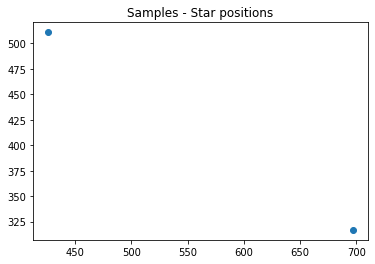

In [77]:
plt.scatter(pos_np[:,0],pos_np[:,1])
plt.title('Samples - Star positions')
plt.show()

In [78]:
poly_psf_multires = []
zernike_coef_multires = []

for gen_poly_fieldPSF in gen_poly_fieldPSF_multires:
    # Generate all the polychromatic PSFs
    poly_psf_list = []
    zernike_coef_list = []

    for it in tqdm(range(n_stars), position=0, leave=True):
        _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[it, 0],
                                                           yv_flat=pos_np[it, 1],
                                                           SED=SED_list[it])
        poly_psf_list.append(_psf)
        zernike_coef_list.append(_zernike) 
    
    poly_psf_multires.append(np.copy(poly_psf_list))
    zernike_coef_multires.append(np.copy(zernike_coef_list))
    

100%|██████████| 2/2 [35:18<00:00, 1059.28s/it]


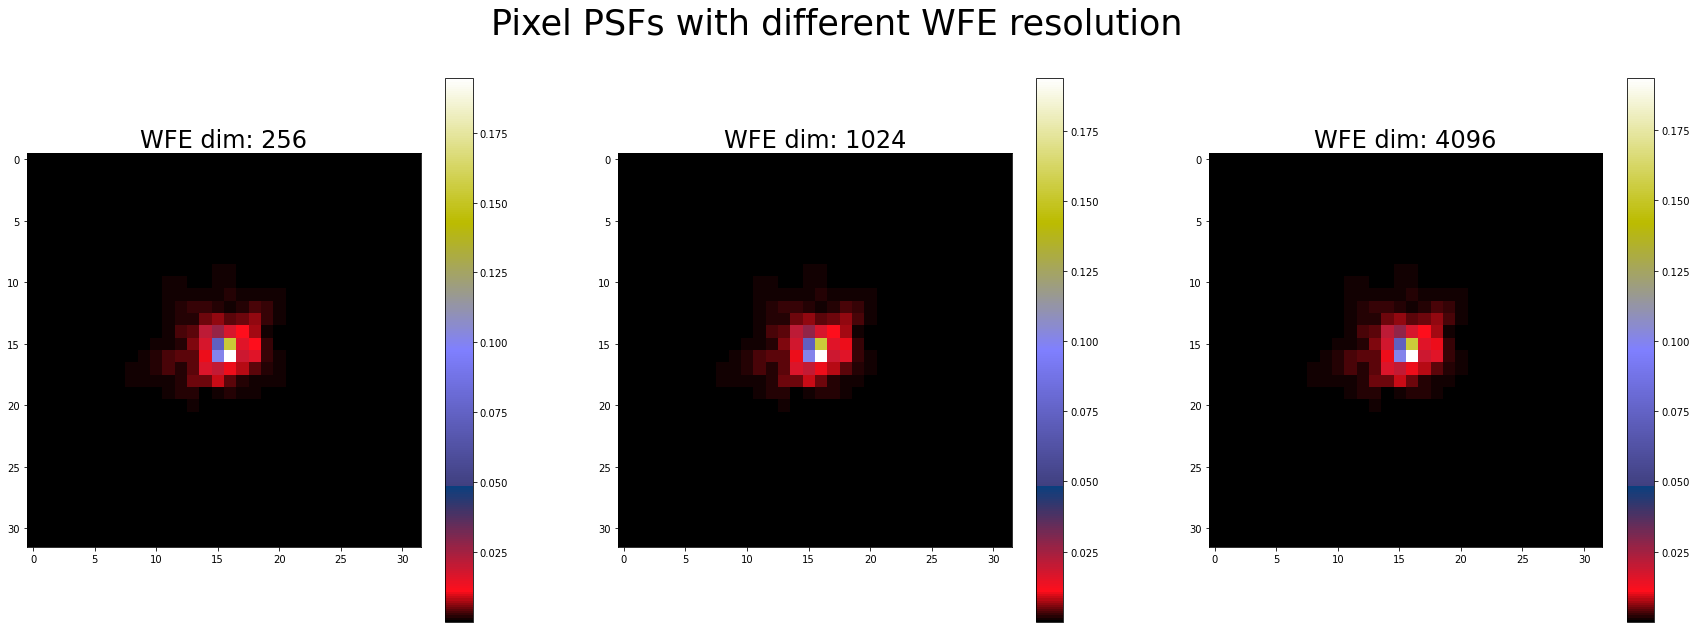

In [80]:
star_to_show = 0

plt.figure(figsize=(30,10))
plt.suptitle('Pixel PSFs with different WFE resolution', fontsize=35)
plt.subplot(131)
plt.imshow(poly_psf_multires[0][star_to_show,:,:], cmap='gist_stern');plt.colorbar()
plt.title('WFE dim: 256', fontsize=24)
plt.subplot(132)
plt.imshow(poly_psf_multires[1][star_to_show,:,:], cmap='gist_stern');plt.colorbar()
plt.title('WFE dim: 1024', fontsize=24)
plt.subplot(133)
plt.imshow(poly_psf_multires[2][star_to_show,:,:], cmap='gist_stern');plt.colorbar()
plt.title('WFE dim: 4096', fontsize=24)
plt.show()

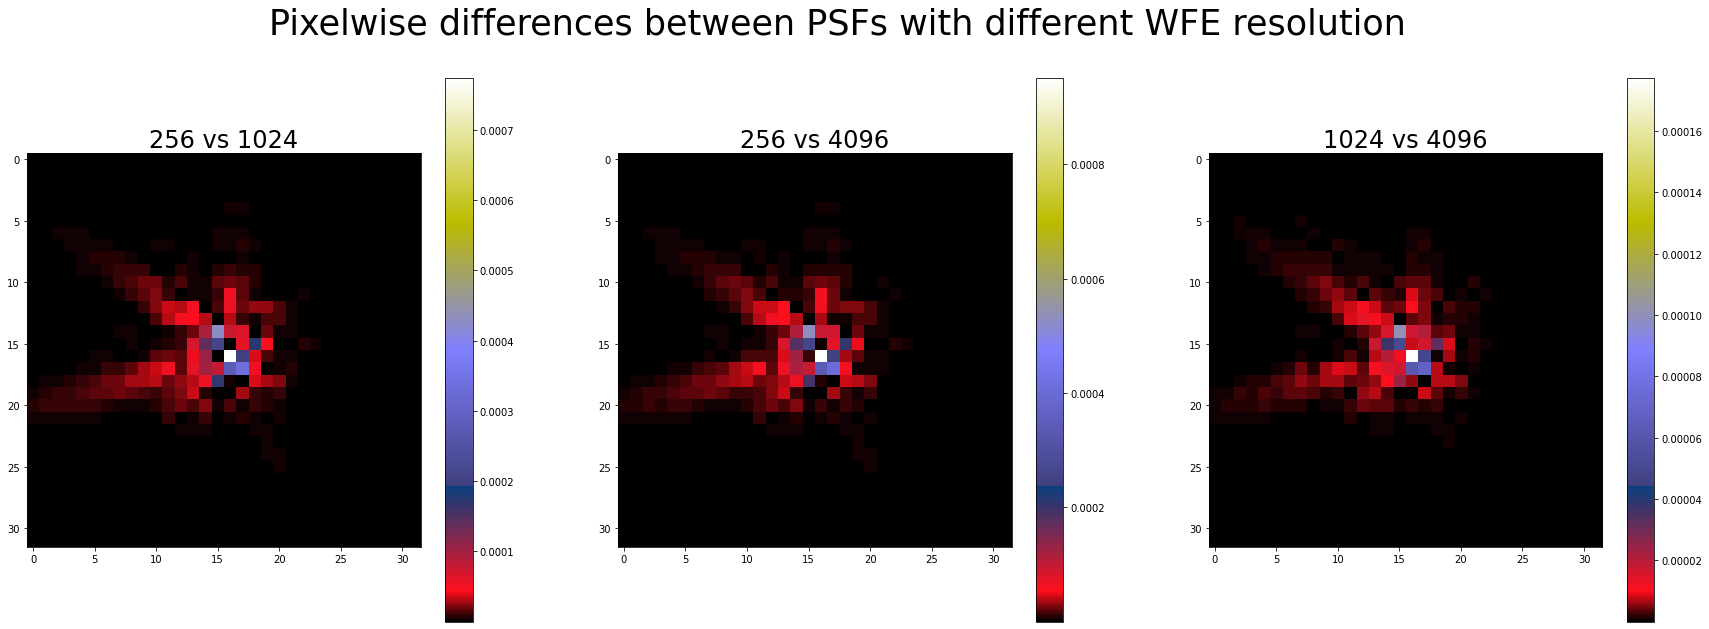

In [81]:
plt.figure(figsize=(30,10))
plt.suptitle('Pixelwise differences between PSFs with different WFE resolution', fontsize=35)
plt.subplot(131)
plt.imshow(np.abs( poly_psf_multires[0][star_to_show,:,:]-poly_psf_multires[1][star_to_show,:,:] ), cmap='gist_stern');plt.colorbar()
plt.title('256 vs 1024', fontsize=24)
plt.subplot(132)
plt.imshow(np.abs( poly_psf_multires[0][star_to_show,:,:]-poly_psf_multires[2][star_to_show,:,:] ), cmap='gist_stern');plt.colorbar()
plt.title('256 vs 4096', fontsize=24)
plt.subplot(133)
plt.imshow(np.abs( poly_psf_multires[2][star_to_show,:,:]-poly_psf_multires[1][star_to_show,:,:] ), cmap='gist_stern');plt.colorbar()
plt.title('1024 vs 4096', fontsize=24)
plt.show()

In [82]:
WFE_res_id = 0

# SNR varying randomly from 10 to 120 - shared over all WFE resolutions
rand_SNR = (np.random.rand(tot_train_stars) * 100) + 10
# # Generate Gaussian noise patterns
# noisy_train_patterns = np.zeros((tot_train_stars, output_dim, output_dim))
# noisy_train_patterns = np.stack([wf_psf.utils.add_noise(_im, desired_SNR=_SNR) 
#                                   for _im, _SNR in zip(noisy_train_patterns, rand_SNR)], axis=0)


# Copy the training stars
train_stars = np.copy(np.array(poly_psf_multires[0])[:tot_train_stars, :, :])
# Add Gaussian noise to the observations
noisy_train_stars = np.stack([wf_psf.utils.add_noise(_im, desired_SNR=_SNR) 
                              for _im, _SNR in zip(train_stars, rand_SNR)], axis=0)
noisy_train_patterns = noisy_train_stars - train_stars


# Generate datasets for every WFE resolution
for poly_psf_list, zernike_coef_list in zip(poly_psf_multires, zernike_coef_multires):
    
    # Generate numpy arrays from the lists
    poly_psf_np = np.array(poly_psf_list)
    zernike_coef_np = np.array(zernike_coef_list)
    SED_np = np.array(SED_list)

    
    # Add same noise dataset to each WFE-resolution dataset
    noisy_train_stars = np.copy(poly_psf_np[:tot_train_stars, :, :]) + noisy_train_patterns


    # Save only one test dataset

    # Build param dicitionary
    dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                     'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                     'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                     'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                     'pupil_diameter':WFE_resolutions[WFE_res_id], 'euclid_obsc':euclid_obsc,
                     'n_stars':n_test_stars}

    # Save dataset C coefficient matrix (reproductible dataset)
    C_poly = gen_poly_fieldPSF.C_poly

    test_psf_dataset = {'stars' : poly_psf_np[tot_train_stars:, :, :],
                         'positions' : pos_np[tot_train_stars:, :],
                         'SEDs' : SED_np[tot_train_stars:, :, :],
                         'zernike_coef' : zernike_coef_np[tot_train_stars:, :, :],
                         'C_poly' : C_poly,
                         'parameters': dataset_params}

    np.save(output_folder + 'test_Euclid_res_id_' + dataset_id_str + '_wfeRes_' + str(WFE_resolutions[WFE_res_id]) + '.npy',
            test_psf_dataset, allow_pickle=True)



    # Save the different train datasets


    for it_glob in range(len(n_star_list)):

        n_train_stars = n_star_list[it_glob]

        # Build param dicitionary
        dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                         'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                         'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                         'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                         'pupil_diameter':WFE_resolutions[WFE_res_id], 'euclid_obsc':euclid_obsc,
                         'n_stars':n_train_stars}

        train_psf_dataset = {'stars' : poly_psf_np[:n_train_stars, :, :],
                         'noisy_stars': noisy_train_stars[:n_train_stars, :, :],
                         'positions' : pos_np[:n_train_stars, :],
                         'SEDs' : SED_np[:n_train_stars, :, :],
                         'zernike_coef' : zernike_coef_np[:n_train_stars, :, :],
                         'C_poly' : C_poly,
                         'parameters': dataset_params}


        np.save(output_folder + 'train_Euclid_res_' + str(n_train_stars) + '_TrainStars_id_' + dataset_id_str + '_wfeRes_' + str(WFE_resolutions[WFE_res_id]) +'.npy',
                train_psf_dataset, allow_pickle=True)
        
    WFE_res_id += 1

## Load datasets and compare

In [85]:
path = output_folder

dataset_256 = np.load(path + 'train_Euclid_res_1_TrainStars_id_001_wfeRes_'+str(WFE_resolutions[1])+'.npy', allow_pickle=True)[()]
dataset_1024 = np.load(path + 'train_Euclid_res_1_TrainStars_id_001_wfeRes_'+str(WFE_resolutions[0])+'.npy', allow_pickle=True)[()]
dataset_4096 = np.load(path + 'train_Euclid_res_1_TrainStars_id_001_wfeRes_'+str(WFE_resolutions[2])+'.npy', allow_pickle=True)[()]

In [86]:
print(np.array_equal(dataset_256['positions'], dataset_1024['positions']))
print(np.array_equal(dataset_1024['positions'], dataset_4096['positions']))


True
True


In [87]:
print(np.array_equal(dataset_256['C_poly'], dataset_1024['C_poly']))
print(np.array_equal(dataset_1024['C_poly'], dataset_4096['C_poly']))

True
True


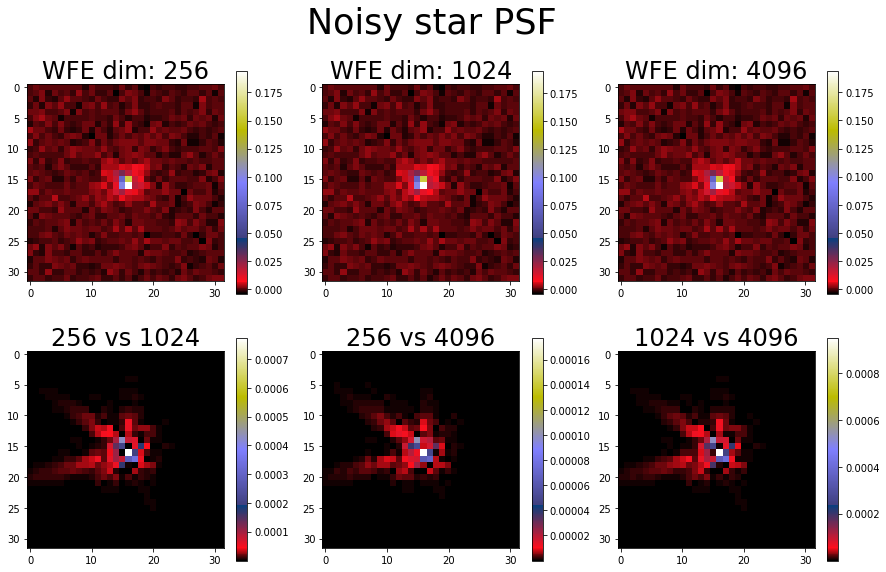

In [89]:
star_to_show = 0

plt.figure(figsize=(15,9))
plt.suptitle('Noisy star PSF', fontsize=35)
plt.subplot(231)
plt.imshow(dataset_256['noisy_stars'][star_to_show,:,:], cmap='gist_stern');plt.colorbar()
plt.title('WFE dim: 256', fontsize=24)
plt.subplot(232)
plt.imshow(dataset_1024['noisy_stars'][star_to_show,:,:], cmap='gist_stern');plt.colorbar()
plt.title('WFE dim: 1024', fontsize=24)
plt.subplot(233)
plt.imshow(dataset_4096['noisy_stars'][star_to_show,:,:], cmap='gist_stern');plt.colorbar()
plt.title('WFE dim: 4096', fontsize=24)
plt.subplot(234)
plt.imshow(np.abs(dataset_256['noisy_stars'][star_to_show,:,:] - dataset_1024['noisy_stars'][star_to_show,:,:] ), cmap='gist_stern');plt.colorbar()
plt.title('256 vs 1024', fontsize=24)
plt.subplot(235)
plt.imshow(np.abs(dataset_256['noisy_stars'][star_to_show,:,:] - dataset_4096['noisy_stars'][star_to_show,:,:] ), cmap='gist_stern');plt.colorbar()
plt.title('256 vs 4096', fontsize=24)
plt.subplot(236)
plt.imshow(np.abs( dataset_1024['noisy_stars'][star_to_show,:,:] - dataset_4096['noisy_stars'][star_to_show,:,:] ), cmap='gist_stern');plt.colorbar()
plt.title('1024 vs 4096', fontsize=24)
plt.show()
